In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import numpy as np
import lsst.sims.maf.stackers as stackers

/Users/yoachim/lsst/DarwinX86/anaconda/2.2.0/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
class AltChangeStacker(stackers.BaseStacker):
    def __init__(self, altCol='altitude', nightCol='night'):
        self.units = ['radians']
        self.colsReq = [altCol, nightCol]
        self.colsAdded = ['altDiff']
        self.altCol = altCol
        
    def _run(self, simData):
        simData['altDiff'][0] = 0.
        simData['altDiff'][1:] = np.abs(simData[self.altCol][1:] - simData[self.altCol][:-1])
        return simData
    


In [3]:
class AltClipMetric(metrics.BaseMetric):
    def __init__(self, altDiffCol = 'altDiff', metricName='altDiff', altChangeMax=9., **kwargs):
        cols = [altDiffCol]
        self.altDiffCol = altDiffCol
        self.altChangeMax = np.radians(altChangeMax)
        super(AltClipMetric, self).__init__(col=cols, metricName=metricName, **kwargs)
    def run(self, dataSlice, slicePoint=None):
        good = np.where(dataSlice[self.altDiffCol] >= self.altChangeMax)[0]
        return good.size

In [4]:
# Set up the database connection
opsdb = db.OpsimDatabase('astro_lsst_01_1000_sqlite.db')
outDir = 'out'
resultsDb = db.ResultsDb(outDir=outDir)

In [5]:
bundleList = []

slicer = slicers.OneDSlicer(sliceColName='night', binsize=1)
metadata = 'Per night'
sqlconstraint = '' 
metric = AltClipMetric()
summaryStats = [metrics.MedianMetric(), metrics.MeanMetric()]
bundle = metricBundles.MetricBundle(metric, slicer, sqlconstraint, summaryMetrics=summaryStats)
bundleList.append(bundle)

Querying database with no constraint.
Found 2448974 visits
Running:  ['opsim_altDiff_ONED']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with  constraint now.
Plotting complete.


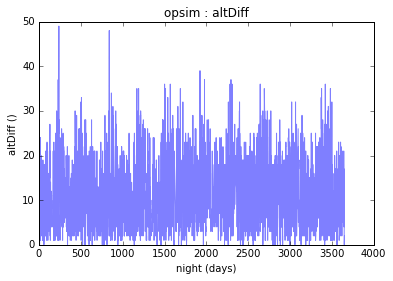

In [6]:
bundleDict = metricBundles.makeBundlesDictFromList(bundleList)
bgroup = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)

In [7]:
bundle.summaryValues

{'Mean': 11.616451932606541, 'Median': 11.0}